# VAMP Score Notes

Let's say we're trying to approximate the [Koopman operator](http://dsbaero.engin.umich.edu/wp-content/uploads/sites/441/2019/07/KoopmanAdamACC19.pdf) for some system with known laws of physics. If you don't know what a "Koopman Operator" is, check out the link. The short version is that given a Markov chain, the Koopman operator is the statistical transition matrix that gives the probabilities of future based on past states. To phrase it a bit more mathematically, so that it generalizes to continuous systems like those found in physics: Given a system with coordinates, we can think about functions of those coordinates as vectors, in the usual way one thinks of functions as vectors. If we time-evolve the system by a fixed amount, functions on the past coordinates are translated into different functions on the future coordinates (if the time evolution is non-deterministic, then we take expectation values). The Koopman operator is the linear operator that maps a function on past coordinates to the expected value of that function on future coordinates. Though it's merely meant to handle systems in classical probability, it is analogous to the unitary time evolution operator in quantum mechanics.

The VAMP score is a number that tells us how well we're approximating the Koopman operator, $K$. Let's consider the Koopman operator corresponding to a characteristic timescale $\Delta t$. We want a good approximation, which means that we want to know the largest singular values and their corresponding singular vectors. Why not eigenvalues and eigenvectors? We can consider a process that looks like the following:

$$
\begin{pmatrix}
    \vec x_{t+1} \\
    \vec y_{t+1}
\end{pmatrix} = \begin{pmatrix}
    \mathbf A & 0 & 0\\
    0 & \mathbf B & 0
\end{pmatrix}\begin{pmatrix}
    \vec \eta \\
    \vec x_t \\
    \vec y_t
\end{pmatrix}
$$

where $\vec \eta$ is a noise source. Then clearly we'd like our approximation of the Koopman operator for this system to basically represent the information contained in the matrix $\mathbf B$. We don't know what the noise will be, so we can't use it to predict the dynamics. But we can use the signular value decomposition, where the left singular vectors give information about $\vec y$, the right singular vectors give information about $\vec x$ and the singular values measure the degree of influence. Eigenvectors are the same on both the left and the right, so they're less appropriate for this application.

Now that we know we should be using singular values, the next question is how to get a good score, which tells us how well we're approximating the dynamics. In the simplest case, we can suppose that we're given left and right feature vectors, $\vec f$, and $\vec g$, respectively. Further, we can suppose that these follow an $n$-dimensional standard normal distribution. i.e. $\text{Cov}(\vec f) = \mathbb{I}$ and $\text{Cov}(\vec g) = \mathbb{I}$. What does this mean precisely, in terms of how we're assigning probabilities? Well, say we sample a state of our system. For example, if we have a bunch of trajectories, we can sample one of the trajectories and then sample a random point in time from the trajectory. We could also say that we're sampling from thermodynamic equilibrium. Though this is often computationally hard, hopefully the resulting distribution is not too different to sampling from trajectories, so we might be able to say that sampling from trajectories is almost as good.

Now give such feature vectors (we can assume that they're both of dimension $N$), what can we say about how good our approximation of the Koopman operator is? Well, we want as much as possible of the variance in $\vec g$ to be explained by the variance in $\vec f$. Any given amount of variance in $\vec g$ will be some portion explained by variance in $\vec f$ and some portion explained by sheer randomness. Let $\vec f_i, \vec g_i$ be right and left singular vectors respectively, with singular value $\sigma_i$. By orthonormality of singular vectors, $\text{Var} (f_i) = \text{Var} (g_i) = 1$. Also, from the definition of the Koopman operator, we have that $\langle g_i \rangle = \sigma_i f_i$. Assuming that any other contribution to $g_i$ is independent (if it weren't, we could absorb the correlation into the Koopman operator), we have: $\text{Var} (g_i) = \sigma_i^2 \text{Var} f_i + \text{Var} (\eta)$. Where $\eta$ is some noise variable. This gives:

$$
1-\sigma_i^2 = \text{Var}(\eta)
$$

Interestingly, this equation confines our singular values to the range $[0,1]$ (by positivity of variance). A natural thing to ask at this point is to maximize $\sum_i \sigma_i^2$. This maximizes the amount of variance explained by our Koopman operator approximation. This is the VAMP-2 score.

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt


### Whitening / Decorrelation

Now, here we benefitted from the fact that $\vec f$ and $\vec g$ have variance $\mathbb{I}$. But in general, if we have some features (outputs of a neural network, say), we can't be sure that they will have this nice of a distribution. Let's say that the raw features (or the ones produced by our neural network) are: $\vec\chi_0$, $\vec \chi_1$ for the input ($\vec f$) and output ($\vec g$) of $K$ respectively. Then we'll have to apply a whitening or decorrelation transform to these vectors to get vectors whose correlation matrix is the identity.


##### Useful Links:
* https://en.wikipedia.org/wiki/Whitening_transformation
* https://en.wikipedia.org/wiki/Canonical_correlation (This is basically what this entire VAMP score procedure is trying to accomplish)


Mathematically, there are various ways one might try to perform a whitening transformation. For this particular case, we just call the diagonalization routine on the raw correlation matrix (this is fast and gives unitary eigenvector matrices, thanks to the original matrix being symmetric). So:

$$
C = Q\Lambda Q^T
$$

Then the transformed data is:

$$
\mathbf{x}' = \Lambda^{-1/2}Q^T \mathbf{x}
$$

In [4]:
class Affine:
    """ Class representing an affine transformation in n-dimensional space """
    def __init__(self, W, mu):
        self.W = W
        self.mu = mu
    def __call__(self, x):
        return (self.W @ (x - self.mu).T).T

def decorr(x, with_transform=True, epsilon=1e-6):
    """ decorrelate (i.e. apply a whitening transformation) to the data vector x with shape (batch, featuredim)
    dimensions where there is no variation will be discarded """
    batch, featuredim = x.shape
    mu = x.mean(0, keepdim=True)
    x = x - mu
    C = torch.cov(x.T)
    lam, Q = torch.linalg.eigh(C)
    keepdim_mask = lam > epsilon # discard dimensions where there is little variation (can't take -0.5 power of non-positive number)
    Q = Q[:, keepdim_mask]
    lam = lam[keepdim_mask]
    W = (1./torch.sqrt(lam)).reshape(-1, 1) * Q.T
    y = (W @ x.T).T
    if with_transform:
        return y, Affine(W, mu)
    return y



In [5]:
# TEST
# this test will be useful later for visualizing the decorrelation process

def decorr_test(f):
    """ Check that the vector f has been decorrelated properly. """
    print(f.mean(0).detach().cpu())
    print(torch.cov(f.T).detach().cpu())
    plt.scatter(f[:, 0].detach().cpu(), f[:, 1].detach().cpu())
    plt.scatter(f[:, 1].detach().cpu(), f[:, 2].detach().cpu())
    plt.scatter(f[:, 2].detach().cpu(), f[:, 0].detach().cpu())
    plt.show()



In [6]:
# QUICK TEST OF WHETHER WE CAN DISCARD DIMENSIONS SUCCESSFULLY
if False:
    chi = torch.eye(10)
    f, trans = decorr(chi)
    print(trans.W.shape) # expect: (9, 10)

### How do we estimate $K$?

Let's say we have a lot of trajectories to work from, and lots of time steps in each trajectory. This gives a good dataset of cases where we have examples of an initial value of $\vec f$ and the resulting value of $\vec g$. Let's say we have $M$ examples, indexed by $m$, so that we have: $\vec f_m, \vec g_m$. Then the natural thing to do is to construct the empirical covariance matrix:

$$
K^T = \frac{1}{M} \sum_{m=1}^M \vec f_m \otimes \vec g_m
$$

The VAMP-2 score, the sums of squares of singular values, can also be given by the squared [Frobenius Norm](https://en.wikipedia.org/wiki/Matrix_norm#Frobenius_norm):

$$
-\mathcal{L} = \sum_{i,j} K_{[i,j]}^2
$$

In [7]:
# VAMP Score

def vamp_score(chi_0, chi_1, mode="score", epsilon=1e-6):
    """ function computing the VAMP-2 score, implemented in torch for differentiability
    chi_0 - right feature vector, shape is (batch, featuredim)
    chi_1 - left feature vector, shape is (batch, featuredim)
    mode - one of several options:
        * "score": return the VAMP score directly (i.e. the Frobenius norm of the matrix)
        * "matrix": just return the estimated truncated Koopman operator (in f,g space) C_10
        * "all": return the decorrelation transformations, and also C_10
    epsilon - eigenvalues of covariance matrix are clipped to be at least this, for numberical stability """
    batch, featuredim = chi_0.shape
    assert chi_1.shape == chi_0.shape
    f, trans_0 = decorr(chi_0) # f.shape: (batch, truncdim_f <= featuredim)
    g, trans_1 = decorr(chi_1) # g.shape: (batch, truncdim_g <= featuredim)
    # compute covariance
    C_aa = torch.cov(torch.cat([f.T, g.T], dim=0))
    C_10 = C_aa[f.shape[1]:, :f.shape[1]] # estimated truncated Koopman operator
    if mode == "score":
        return (C_10**2).sum()
    elif mode == "matrix":
        return C_10
    elif mode == "all":
        return trans_0, trans_1, C_10
    else:
        assert False, "invalid mode passed"



In [8]:
# TESTS
# In this cell are some basic tests of the VAMP score code.
# You can run these after making a change to see if you still obtain the expected results.

def normal_indep_test():
    print("Test with completely indepedent variables (results should be *close* to 0, but not absolutely tiny, due to sampling error)")
    for batch in [100, 300, 1000, 3000, 10000]:
        batch = 500
        featuredim = 3
        chi_0 = torch.randn(batch, featuredim)
        chi_1 = torch.randn(batch, featuredim)
        print(vamp_score(chi_0, chi_1)) # variance explained: 0 + 0 == 0

def simple2d_test_identity():
    """ for debug checking: call inline_fg_normality_test(chi_0, chi_1, L_0, L_1) """
    print("Simple test in two dimensions with identity mapping!")
    for batch in [100, 300, 1000, 3000, 10000]:
        x = torch.randn(batch, 2)
        x[:, 1] += x[:, 0]
        x[:, 0] += 6 # test with non-zero mean
        chi_0 = x
        chi_1 = x
        print(vamp_score(chi_0, chi_1)) # variance explained: 1 + 1 == 2

def simple2d_test_perturb():
    """ for debug checking: call inline_fg_normality_test(chi_0, chi_1, L_0, L_1) """
    print("Simple test in two dimensions with mapping that adds some noise")
    for batch in [100, 300, 1000, 3000, 10000]:
        x = torch.randn(batch, 2)
        y = torch.zeros_like(x)
        y[:, 1] = x[:, 0]*0.5 + torch.randn(batch)
        y[:, 0] += x[:, 1] + torch.randn(batch)
        y[:, 1] *= 100
        y[:, 0] *= 50
        print(vamp_score(x, y)) # variance explained: 0.5 + 0.2 == 0.7

if False: # change to True to run the tests
    normal_indep_test()
    simple2d_test_identity()
    simple2d_test_perturb()



### Useful references:
Barlow twins - https://browse.arxiv.org/pdf/2103.03230.pdf
VAMP score - https://deeptime-ml.github.io/latest/notebooks/vamp.html
https://www.dropbox.com/home/Transfer_Operator_Project/literature?preview=state_free_VAMP_nets.pdf
VAMPnets: Deep learning of molecular kinetics - https://browse.arxiv.org/pdf/1710.06012v1.pdf



Experiment Grid (in order of simplicity):

* TICA (chi_0 = chi_1 = coordinates)
* VAMPnets

cross

* 1D ornstein uhlenbeck
* 1D nonlinear
* Polymer in 1D
* Polymer in 3D

Compare spectra of singular values

### Running simulations

Next, we'll want to be able to run physics simulations. It turns out that a good thing to use for this is a symplectic integrator. These conserve phase-volume which makes them more stable for physics applications. We'll use the Velocity-Verlet method here, which is a good 2nd order method. More information: https://www.av8n.com/physics/symplectic-integrator.htm

We also want to incorporate thermal noise into the dynamics. i.e. we want [Langevin dynamics](https://en.wikipedia.org/wiki/Langevin_dynamics). This has been done in a not particularly principled way (i.e. accuracy is probably 1st order) here:

In [9]:

def vvel_lng_batch(x, v, a, drag, T, dt, nsteps):
    """ Langevin dynamics with Velocity-Verlet.
    Batched version: compute multiple trajectories in parallel
    This function mutates the position (x) and velocity(v) arrays.
    Compute nsteps updates of the system: We're passed x(t=0) and v(t=0) and
    return x(dt*nsteps), v(dt*nsteps). Leapfrog updates are used for the intermediate steps.
    a(x) is the acceleration as a function of the position.
    drag[] is a vector of drag coefficients to be applied to the system.
    T is the temperature in units of energy.
    dt is the timestep size.
    Shapes:
    x: (batch, coorddim)
    v: (batch, coorddim)
    drag: (coorddim,)
    a: (-1, coorddim) -> (-1, coorddim)
    return = x:(batch, coorddim), v:(batch, coorddim)"""
    assert nsteps >= 1
    assert x.shape == v.shape and drag.shape == x.shape[1:]
    noise_coeffs = np.sqrt(2*drag*T*dt) # noise coefficients for a dt timestep
    def randn():
        return np.random.randn(*x.shape)
    v += 0.5*(dt*(a(x) - drag*v) + np.sqrt(0.5)*noise_coeffs*randn())
    for i in range(nsteps - 1):
        x += dt*v
        v += dt*(a(x) - drag*v) + noise_coeffs*randn()
    x += dt*v
    v += 0.5*(dt*(a(x) - drag*v) + np.sqrt(0.5)*noise_coeffs*randn())
    return x, v


### Polymer Dynamics

The simplest polymer model is the "Gaussian Chain", where the potential energy is quadratic and has its minimum at 0 separation of successive atoms in the chain. These harmonic springs connecting the atoms are the only force in the system, the atoms can otherwise pass through each other like ghosts. This very simple system is exactly solvable with Rouse modes.


In [10]:

def get_polymer_a(k, n, dim=3):
    """ Get an acceleration function defining a polymer system with n atoms and spring constant k
    Shapes:
    x: (batch, n*dim)
    a: (batch, n*dim) """
    def a(x):
        x = x.reshape(-1, n, dim)
        ans = np.zeros_like(x)
        ans[:, 1:] += k*(x[:, :-1] - x[:, 1:])
        ans[:, :-1] += k*(x[:, 1:] - x[:, :-1])
        return ans.reshape(-1, n*dim)
    return a


### Defining systems to be simulated.

Here's our list of systems we'd like to simulate:

* [Ornstein Uhlenbeck Process](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process) (Velocity is overdamped, i.e. pretty much randomized at each timestep. Quadratic potential and so exactly solvable.)
* Another 1D velocity-overdampled process, but this one in a non-quadratic potential
* Polymer in 1D (either overdamped or not)
* Polymer in 3D (not-overdamped)

In [11]:

class TrajectorySim:
    def __init__(self, acc_fn, drag, T, delta_t, t_res):
        """ Object representing a physical system for which we can generate trajectories.
        acc_fn : function defining the system, gives acceleration given position
        drag : vector of drag coefficients, also gives the shape of the position vector
        T : temperature
        delta_t : time spacing at which we take samples
        t_res : time resolution, number of individual simulation steps per delta_t """
        self.acc_fn = acc_fn
        self.drag = drag
        self.T = T
        self.delta_t = delta_t
        self.t_res = t_res
        self.dt = delta_t/t_res
        self.dim = drag.flatten().shape[0]
    def generate_trajectory(self, batch, N, initial_x=None, initial_v=None):
        x_traj = np.zeros((batch, N, self.dim))
        v_traj = np.zeros((batch, N, self.dim))
        if initial_x is None: initial_x = np.zeros((batch,) + self.drag.shape)
        if initial_v is None: initial_v = np.zeros((batch,) + self.drag.shape)
        x = initial_x.copy()
        v = initial_v.copy()
        for i in range(N):
            vvel_lng_batch(x, v, self.acc_fn, self.drag, self.T, self.dt, self.t_res)
            x_traj[:, i] = x
            v_traj[:, i] = v
        return x_traj, v_traj


# define the various kinds of simulations:
polymer_length = 12
def nonlin_V(x):
    """ The non-linear potential from the state-free vamp nets paper
    (https://www.dropbox.com/home/Transfer_Operator_Project/literature?preview=state_free_VAMP_nets.pdf) """
    return 2*(x**8 + 0.8*np.exp(-80*x**2) + 0.2*np.exp(-80*(x-0.5)**2) + 0.5*np.exp(-80*(x+0.5)**2))
def nonlin_a(x):
    epsilon = 0.00001
    return -(nonlin_V(x+epsilon) - nonlin_V(x-epsilon))/(2*epsilon)


sims = {
    "1D Ornstein Uhlenbeck": TrajectorySim(
        (lambda x: -x),
        np.array([10.]), 1.0,
        3.0, 60
    ),
    "1D Nonlinear": TrajectorySim(
        nonlin_a,
        np.array([10.]), 1.0,
        1.0, 20
    ),
    "1D Polymer, Ornstein Uhlenbeck": TrajectorySim(
        get_polymer_a(1.0, polymer_length, dim=1),
        np.array([10.]*polymer_length), 1.0,
        1.0, 20
    ),
    "3D Polymer, Langevin": TrajectorySim(
        get_polymer_a(1.0, polymer_length, dim=3),
        np.array([0.2]*polymer_length), 1.0,
        1.0, 20
    ),
}


In [12]:
# TESTS
# check that the trajectories look right

if False:
    x_t, v_t = sims["1D Ornstein Uhlenbeck"].generate_trajectory(1, 400)
    plt.plot(x_t[0])
    plt.show()

if False:
    x_t, v_t = sims["1D Nonlinear"].generate_trajectory(1, 400)
    plt.plot(x_t[0])
    plt.show() # note the clumping according to the valleys in the potential

if False:
    # we can also check that ornstein uhlenbeck is velocity-overdamped by setting v very high and seeing how fast it decays:
    x_t, v_t = sims["1D Ornstein Uhlenbeck"].generate_trajectory(1, 100, initial_v = np.array([[100.0]]))
    plt.plot(x_t[0])
    plt.plot(v_t[0])
    plt.show()


In [13]:
# PLOT EIGENFUNCTIONS

def plot_eigenthings(sing_vals, get_eigenfeature_0, get_eigenfeature_1, scalefn=(lambda x: 1.), range=(-4,4)):
    """ plot Koopman singular values and singular vectors for a 1D system """
    x = torch.linspace(*range, 240).reshape(240, 1)
    ef_0 = get_eigenfeature_0(x) * scalefn(x)
    ef_1 = get_eigenfeature_1(x) * scalefn(x)
    # do plotting
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, width_ratios=[1, 4, 4], figsize=(16, 8))
    x1, y1 = np.array([0., 1.]), np.array([1., 1.])
    for i, sigma in enumerate(sing_vals):
        ax1.plot(x1, sigma*y1)
        ax2.plot(x, ef_0[:, i])
        ax3.plot(x, ef_1[:, i])
    ax1.set_ylim(0., 1.)
    ax1.get_xaxis().set_visible(False)
    ymin, ymax = min(ef_0.min(), ef_1.min()), max(ef_0.max(), ef_1.max())
    ax2.set_ylim(ymin, ymax)
    ax3.set_ylim(ymin, ymax)
    ax3.get_yaxis().set_visible(False)
    plt.show()


### Dataset Generation

We need to generate a bunch of trajectories to be our dataset. Since we aren't providing a proper initial condition, it will default to (x=0, v=0). Thus we need to leave some time to equilibriate.

In [14]:

def get_dataset(sim, N, L, device="cpu"):
    dataset = np.zeros((N, L, sim.dim)) # just training on position coordinates for now. training on velocity too makes dim twice as large
    t_eql = 120 # number of delta_t to wait to system to equilibriate, data before this point is thrown away
    x_traj, _ = sim.generate_trajectory(N, L+t_eql)
    dataset = x_traj[:, t_eql:]
    return torch.tensor(dataset, dtype=torch.float32, device=device)


---
### END OF NECESSARY DEFINITONS
----

### Analysis

We can now actually proceed to analyze these simple systems.  We'll start with 1-D Ornstein-Uhlenbeck and generate a reasonably large number of trajectories. We'll need to check that the system successfully equilibriated before the start of our trajectories (we expect that the variance should be equal to 1 for this potential). Our raw coordinate is just the 1D $x$ coordinate. To get features that are more interesting, we'll take our features to be powers of $x$.

In [15]:
dataset = get_dataset(sims["1D Ornstein Uhlenbeck"], 10000, 100)
start_positions = dataset[:, 0]
print((start_positions*start_positions).mean() - (start_positions.mean())**2) # check that equilibriation worked, should equal nearly 1

tensor(0.9719)


In [16]:
# FEATURES ARE POWERS OF X

def get_powers_of_x(x):
    """ powers of x where x.shape == (batch, 1) """
    x_powers = [x]
    for i in range(3):
        x_powers.append(x*x_powers[-1])
    return torch.cat(x_powers, dim=1)


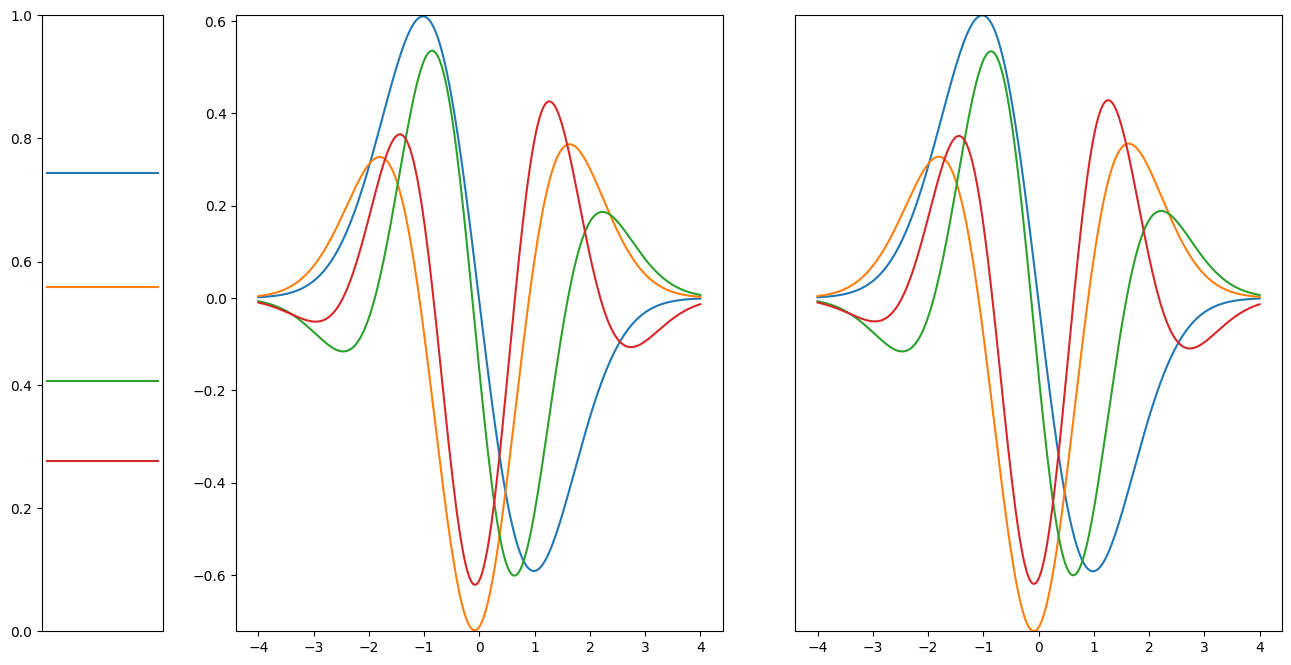

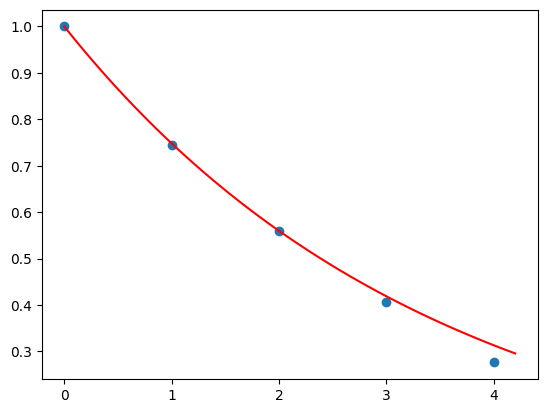

tensor([[-1.6499e-02, -9.8686e-01,  2.3233e-02, -3.7956e-03,  5.4630e-04],
        [-1.0022e+00,  1.8379e-01,  7.2290e-01, -5.0295e-02, -4.5644e-03],
        [-2.4031e-02, -1.2037e+00,  2.1650e-01,  3.9716e-01, -1.6072e-02],
        [-3.0120e+00,  2.4588e-01,  1.2443e+00, -9.8905e-02, -2.1142e-01]])


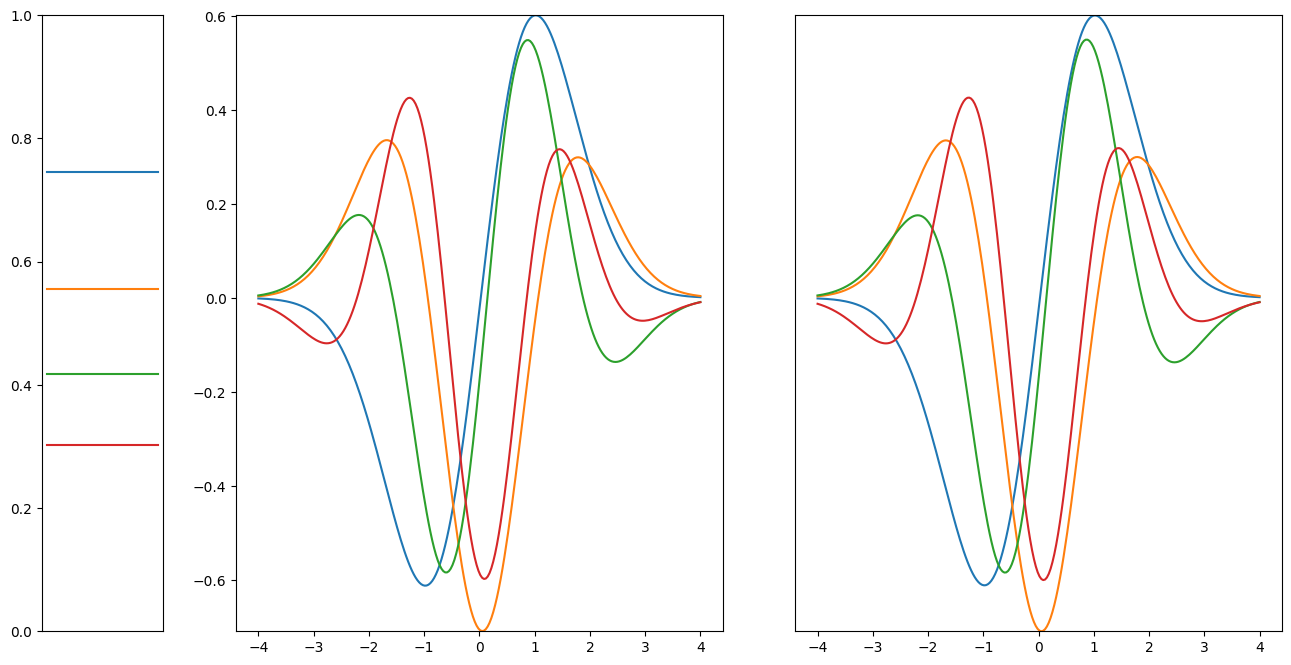

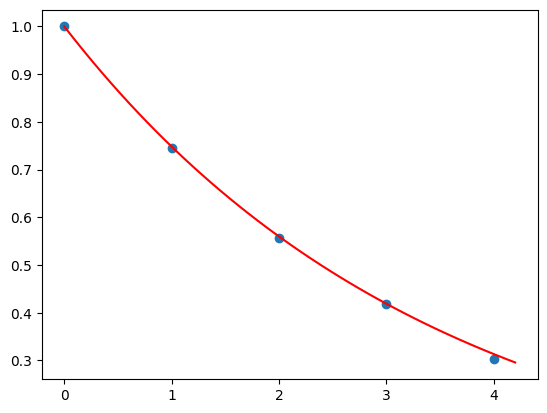

tensor([[-9.2737e-03,  9.9972e-01,  1.6014e-02,  1.3061e-04,  8.6162e-06],
        [-9.9822e-01, -1.1594e-01,  7.0699e-01,  2.2943e-02,  2.0461e-05],
        [-4.4197e-02,  1.1868e+00,  3.0668e-01, -3.9785e-01, -4.0544e-02],
        [-2.9823e+00, -2.7295e-01,  1.1791e+00,  9.3830e-02, -1.9885e-01]])


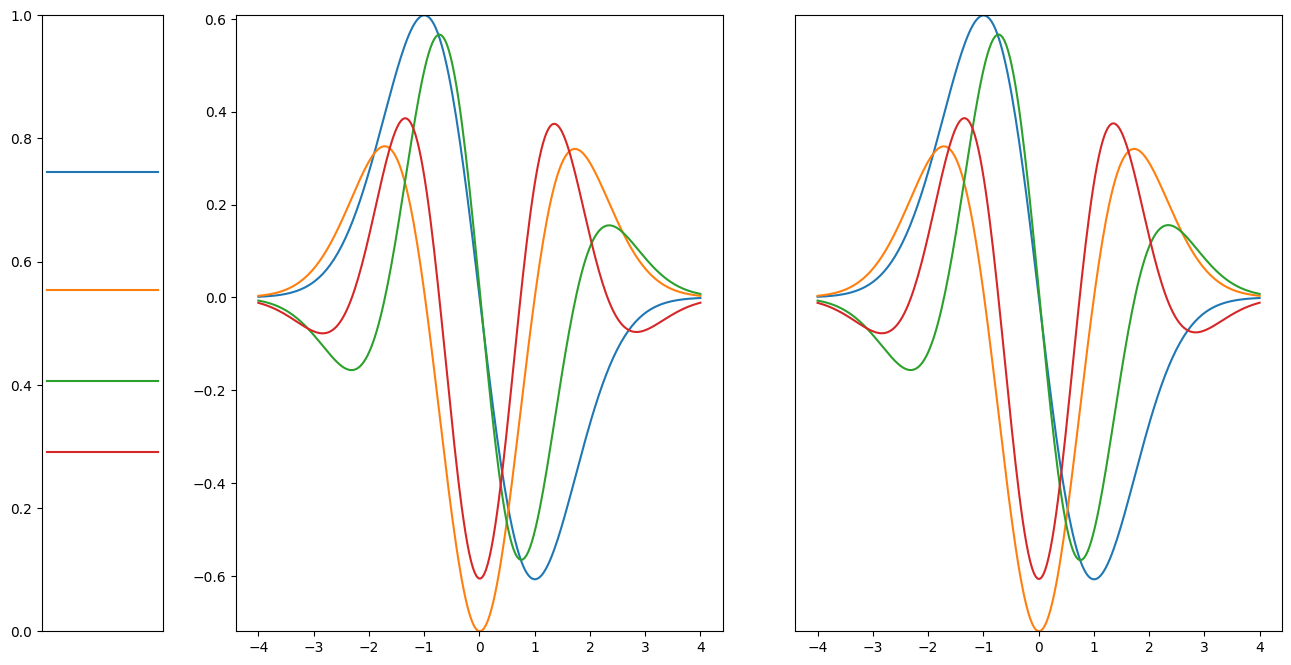

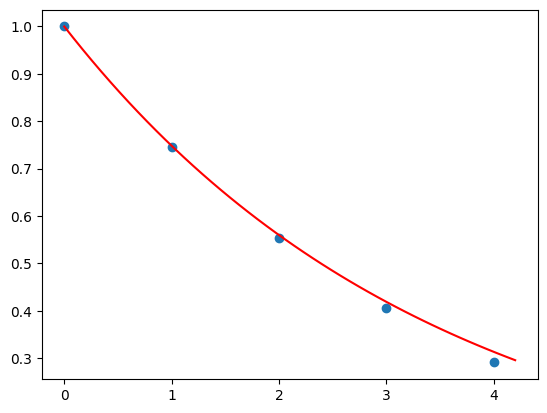

tensor([[-3.9722e-04, -1.0018e+00, -3.7701e-03,  2.6414e-05, -2.3478e-05],
        [-9.9648e-01, -1.6627e-02,  7.3336e-01,  3.1411e-03, -3.8200e-03],
        [-2.7539e-03, -1.2310e+00, -4.3513e-02,  4.1274e-01,  6.8866e-03],
        [-2.9724e+00, -2.2558e-02,  1.2329e+00,  6.3641e-03, -2.0947e-01]])


In [17]:
# ANALYZE

N, L, _ = dataset.shape
# check what happens if we use a subset of the data
for N_cut in [N//100, N//10, N]:
    # have to reshape first since the feature functions just expect a shape of (batch, coorddim)
    chi_0 = get_powers_of_x(dataset[:N_cut, :-1].reshape(N_cut*(L-1), -1))
    chi_1 = get_powers_of_x(dataset[:N_cut, 1: ].reshape(N_cut*(L-1), -1))
    trans_0, trans_1, K = vamp_score(chi_0, chi_1, mode="all")
    #f = trans_0(chi_0); decorr_test(f)
    #g = trans_1(chi_1); decorr_test(g)
    U, S, Vh = torch.linalg.svd(K)
    trans_0 = Affine( Vh @ trans_0.W, trans_0.mu)
    trans_1 = Affine(U.T @ trans_1.W, trans_1.mu)
    get_eigenfeature_0 = lambda x: trans_0(get_powers_of_x(x))
    get_eigenfeature_1 = lambda x: trans_1(get_powers_of_x(x))
    plot_eigenthings(S, get_eigenfeature_0, get_eigenfeature_1, lambda x: np.exp(-0.5*x*x))
    # MANUAL EXPONENTIAL FIT TO DATA:
    if True:
        S = torch.cat([torch.tensor([1]), S]) # add in the datapoint corresponding to "const" with eigenvalue 1
        plt.scatter(np.arange(len(S)), S)
        plt.plot(np.linspace(0., 4.2), np.exp(-0.29*(np.linspace(0., 4.2))), color="r")
        plt.show()
    # HERMITE CHECK:
    if True:
        print(torch.cat([-trans_0.mu.reshape(-1, 1), trans_0.W], dim=1)) # rows should match Hermite Polynomials
S_ou_power = S


In terms of shape, we see that the eigenvalues do indeed form an exponential decay, while the first 3 of the 4 rows are proportional to [Hermite polynomials](https://en.wikipedia.org/wiki/Hermite_polynomials). The last row seems a little off, though its shape is still roughly correct. Using less data gives less precise results...

### From Polynomial Features to Grid-based Features

Above, we got the features of from the coordinate by taking powers. Now we should follow a different method, and use a grid. The feature for a given coordinate is then given by a 1-hot vector corresponding to the position of the particle in the grid.

In [18]:
# FEATURES ARE 1-HOT VECTORS OBTAINED FROM PARTICLE POSITION IN THE GRID

GRID_RES = 128 # number of grid points

def randn_cdf(x):
    """ cumulative distribution function of the standard normal distribution """
    return 0.5 * (1 + torch.special.erf(x/np.sqrt(2)))

def get_grid_vector(x):
    """ 1-hot vector based on the position of x in a grid where x.shape == (batch, 1) """
    x = torch.tensor(x)
    batch = x.shape[0]
    idx = (GRID_RES * randn_cdf(x)).long().reshape(batch)
    return torch.nn.functional.one_hot(idx, GRID_RES).float()


In [19]:
# TEST GRID FEATURE
if False:
    x = np.linspace(-3.4, 3.4, 2000).reshape(-1, 1)
    print(get_grid_vector(x).shape)
    print(get_grid_vector(x).dtype)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    ax1.plot(x, (np.arange(GRID_RES).reshape(1, GRID_RES) * get_grid_vector(x).numpy()).sum(1))
    x = x[900:1100]
    ax2.plot(x, (np.arange(GRID_RES).reshape(1, GRID_RES) * get_grid_vector(x).numpy()).sum(1))
    plt.show()


/tmp/ipykernel_49710/1608678586.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


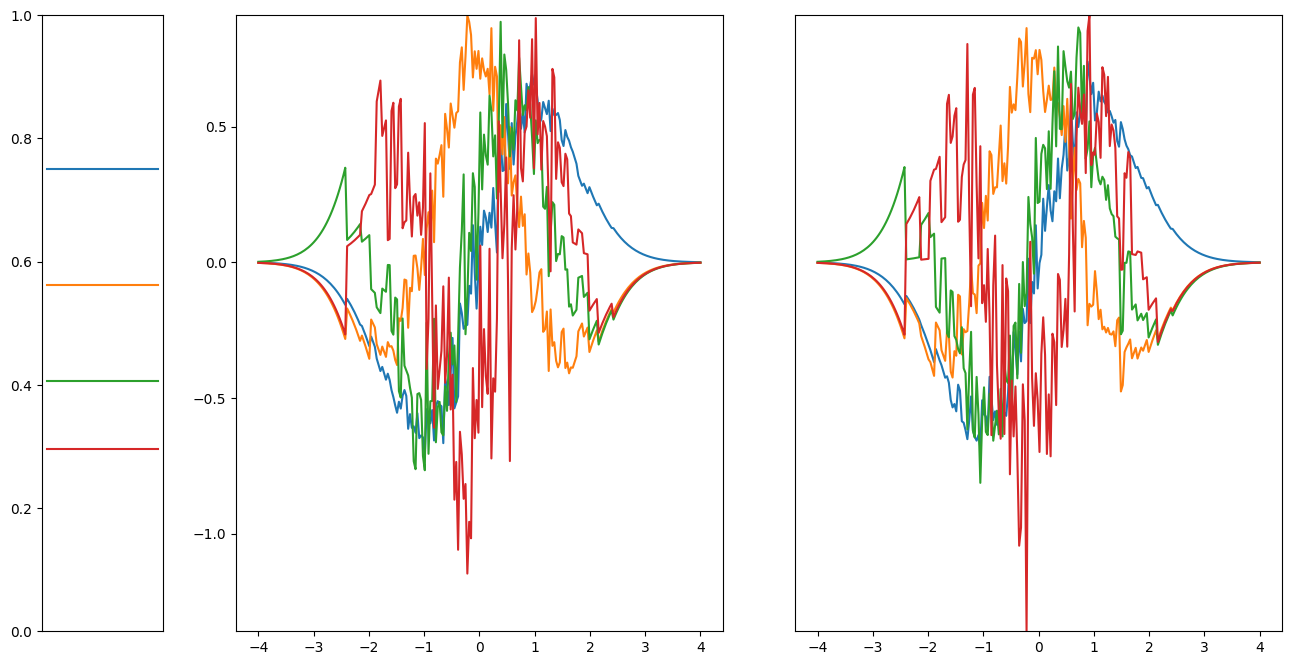

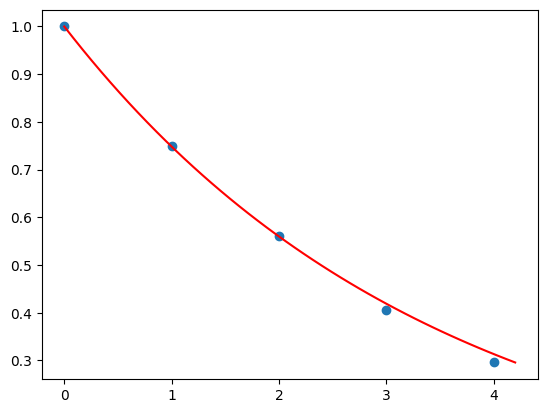

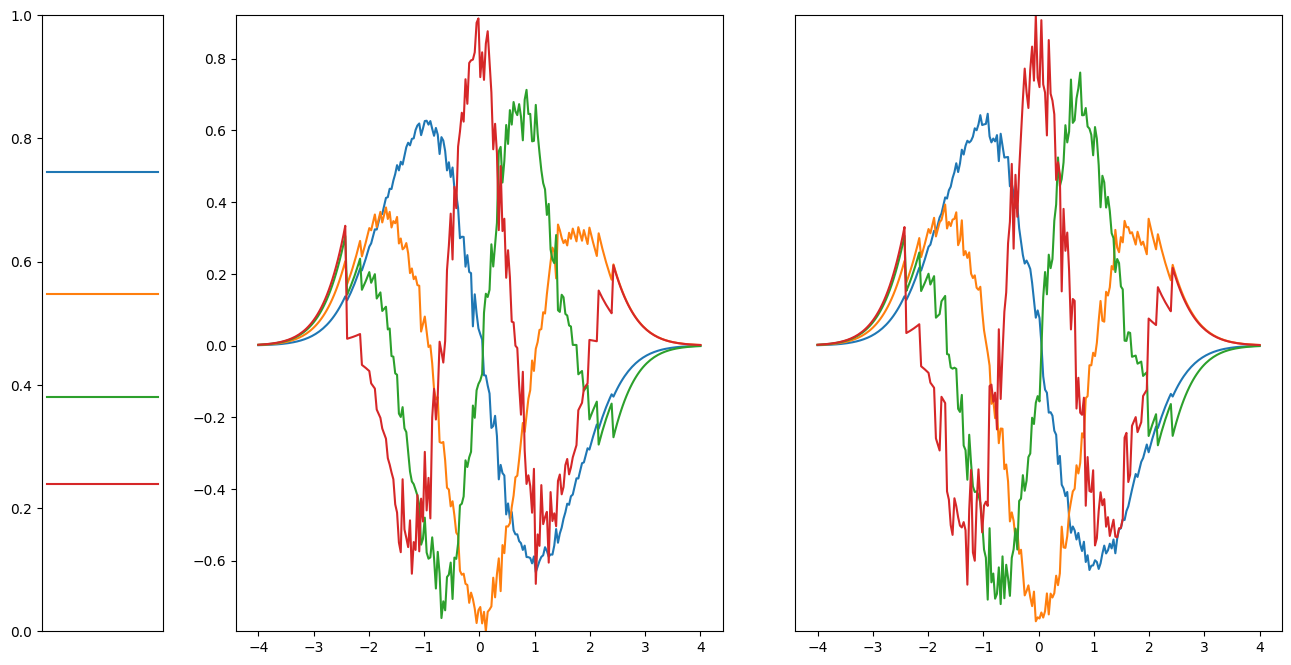

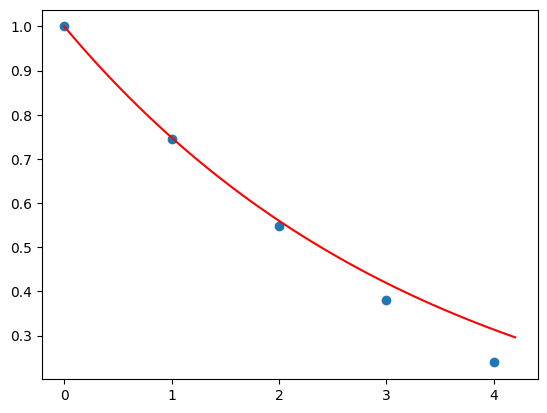

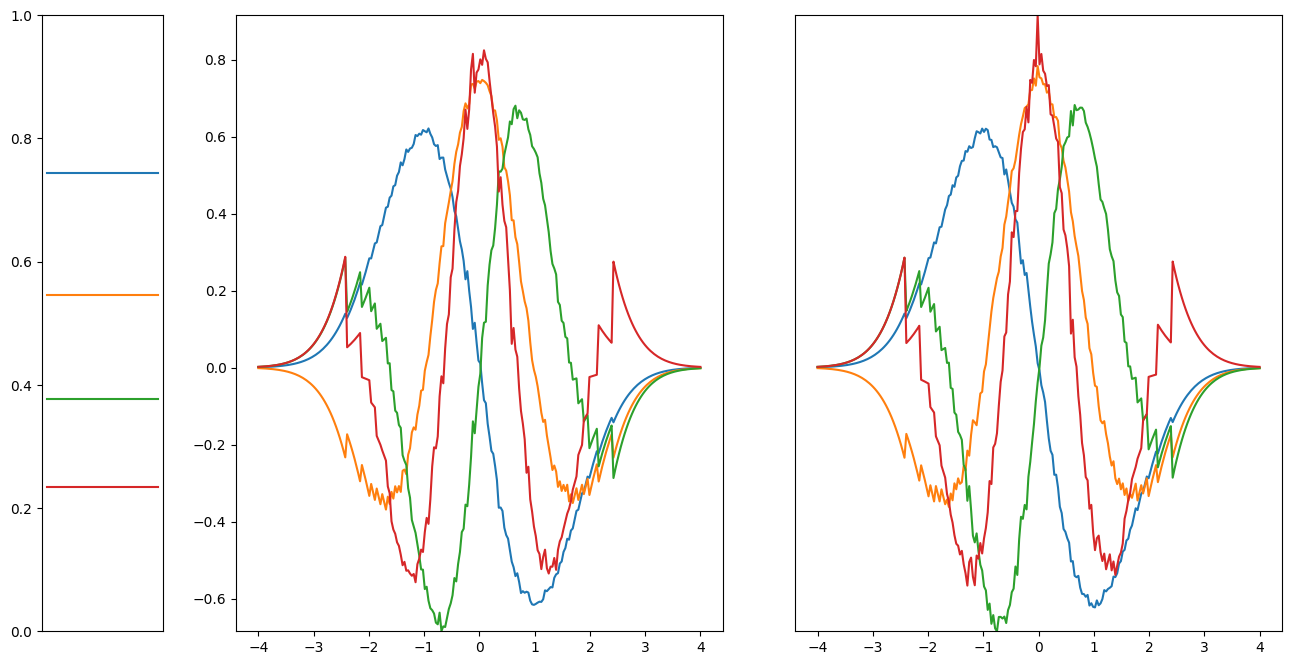

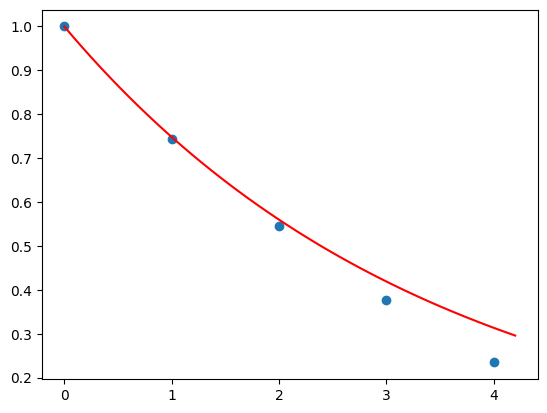

In [20]:
# ANALYZE

N, L, _ = dataset.shape
# check what happens if we use a subset of the data
for N_cut in [N//100, N//10, N]:
    # have to reshape first since the feature functions just expect a shape of (batch, coorddim)
    chi_0 = get_grid_vector(dataset[:N_cut, :-1].reshape(N_cut*(L-1), -1))
    chi_1 = get_grid_vector(dataset[:N_cut, 1: ].reshape(N_cut*(L-1), -1))
    trans_0, trans_1, K = vamp_score(chi_0, chi_1, mode="all")
    #f = trans_0(chi_0); decorr_test(f)
    #g = trans_1(chi_1); decorr_test(g)
    U, S, Vh = torch.linalg.svd(K)
    trans_0 = Affine( Vh @ trans_0.W, trans_0.mu)
    trans_1 = Affine(U.T @ trans_1.W, trans_1.mu)
    # TRUNCATE TO G MOST SIGNIFICANT
    G = 4
    S = S[:G]
    get_eigenfeature_0 = lambda x: trans_0(get_grid_vector(x))[:, :G]
    get_eigenfeature_1 = lambda x: trans_1(get_grid_vector(x))[:, :G]
    plot_eigenthings(S, get_eigenfeature_0, get_eigenfeature_1, lambda x: np.exp(-0.5*x*x))
    # MANUAL EXPONENTIAL FIT TO DATA:
    if True:
        S = torch.cat([torch.tensor([1]), S]) # add in the datapoint corresponding to "const" with eigenvalue 1
        plt.scatter(np.arange(len(S)), S)
        plt.plot(np.linspace(0., 4.2), np.exp(-0.29*(np.linspace(0., 4.2))), color="r")
        plt.show()
S_ou_grid = S


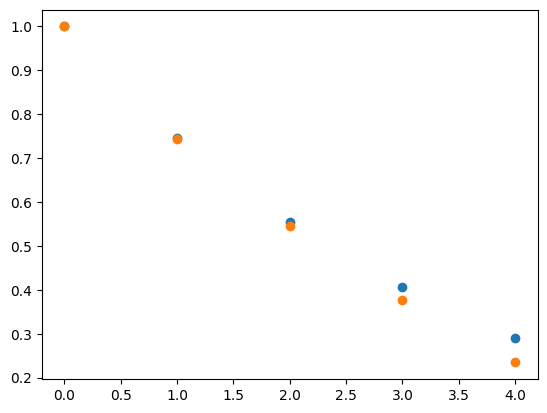

In [21]:
# COMPARISON OF TECHNIQUES
plt.scatter(np.arange(len(S_ou_power)), S_ou_power)
plt.scatter(np.arange(len(S_ou_grid)), S_ou_grid)
plt.show()

### Analyzing the non-linear system:

Now we can use the same techniques on the non-linear 1D system. We'll use the grid features, specifically. The first order of business is to get a new dataset for the dynamics of this system:


In [22]:
dataset_nonlin = get_dataset(sims["1D Nonlinear"], 10000, 100)
print(dataset_nonlin.max(), dataset_nonlin.min())

tensor(1.2376) tensor(-1.2629)


In [23]:
def get_nonlin_grid_vector(x):
    """ 1-hot vector based on the position of x in a grid where x.shape == (batch, 1) """
    x = torch.tensor(x)
    batch = x.shape[0]
    x = torch.clamp(x, -0.999, 0.999)
    idx = (GRID_RES * (1 + x)/2).long().reshape(batch)
    return torch.nn.functional.one_hot(idx, GRID_RES).float()

/tmp/ipykernel_49710/3796692908.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)
/tmp/ipykernel_49710/1608678586.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


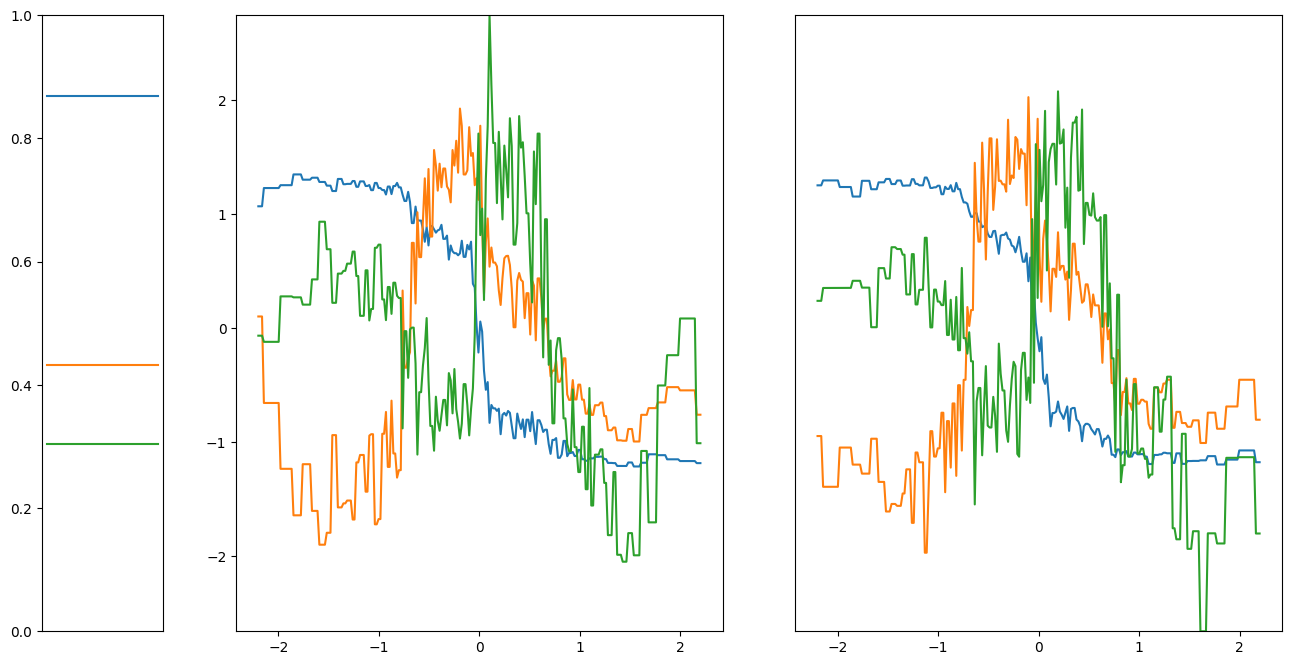

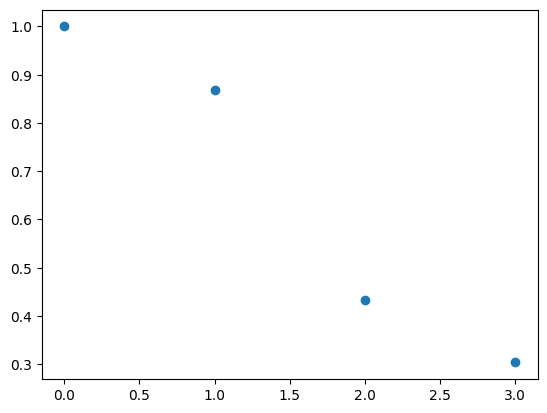

tensor([1.0000, 0.8692, 0.4327, 0.3035])


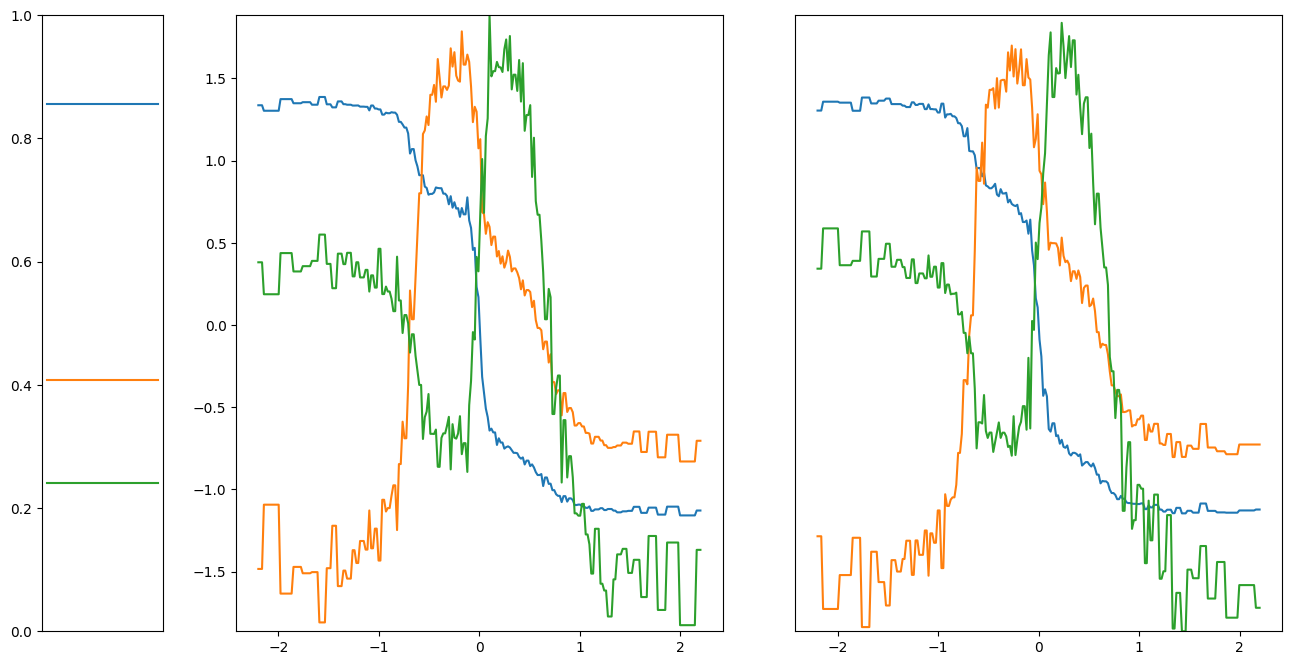

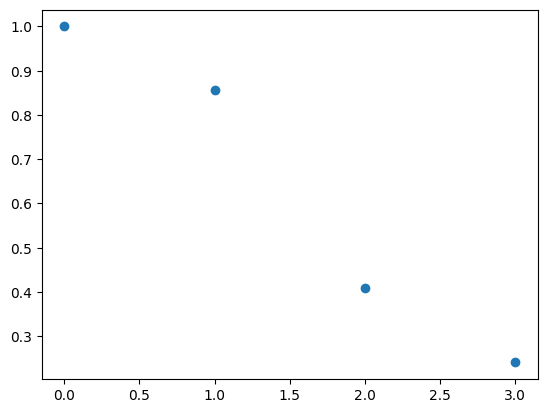

tensor([1.0000, 0.8556, 0.4083, 0.2405])


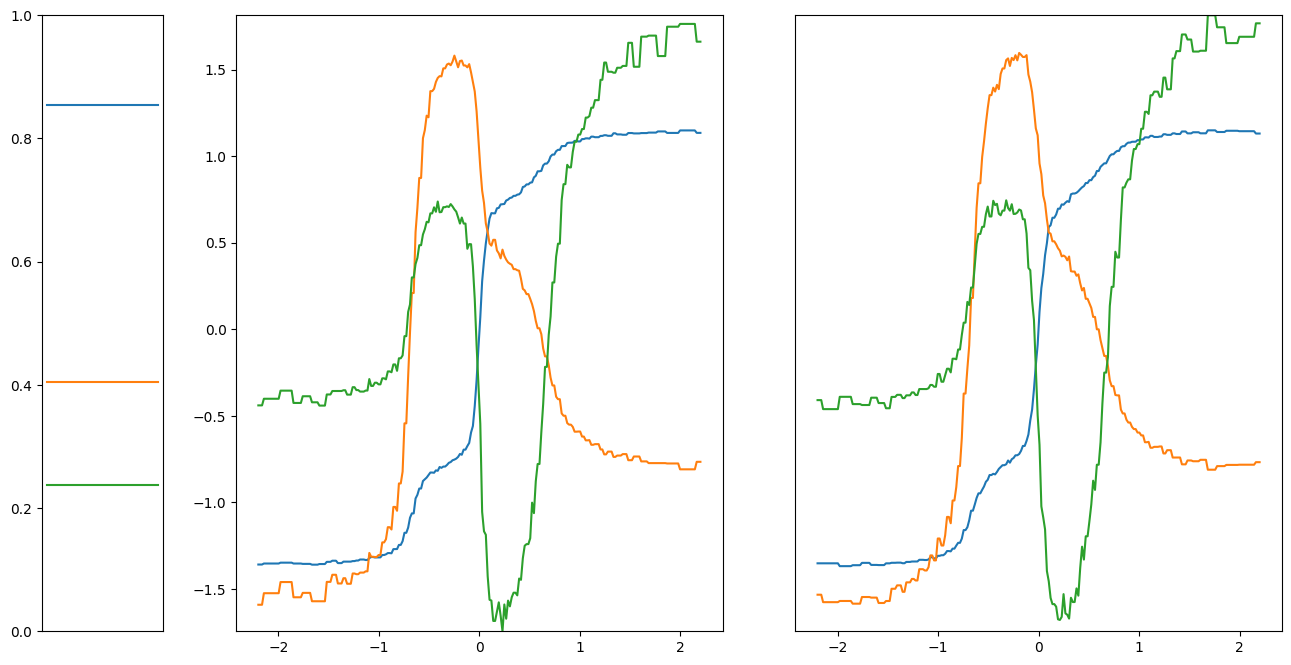

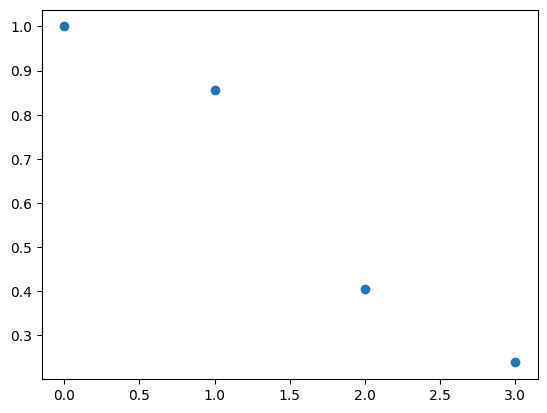

tensor([1.0000, 0.8550, 0.4052, 0.2382])


In [24]:
# ANALYZE

N, L, _ = dataset_nonlin.shape
# check what happens if we use a subset of the data
for N_cut in [N//100, N//10, N]:
    # have to reshape first since the feature functions just expect a shape of (batch, coorddim)
    chi_0 = get_nonlin_grid_vector(dataset_nonlin[:N_cut, :-1].reshape(N_cut*(L-1), -1))
    chi_1 = get_nonlin_grid_vector(dataset_nonlin[:N_cut, 1: ].reshape(N_cut*(L-1), -1))
    trans_0, trans_1, K = vamp_score(chi_0, chi_1, mode="all")
    #f = trans_0(chi_0); decorr_test(f)
    #g = trans_1(chi_1); decorr_test(g)
    U, S, Vh = torch.linalg.svd(K)
    trans_0 = Affine( Vh @ trans_0.W, trans_0.mu)
    trans_1 = Affine(U.T @ trans_1.W, trans_1.mu)
    # TRUNCATE TO G MOST SIGNIFICANT
    G = 3
    S = S[:G]
    get_eigenfeature_0 = lambda x: trans_0(get_grid_vector(x))[:, :G]
    get_eigenfeature_1 = lambda x: trans_1(get_grid_vector(x))[:, :G]
    plot_eigenthings(S, get_eigenfeature_0, get_eigenfeature_1, range=(-2.2, 2.2))
    # EIGENVALUE SCATTERPLOT
    if True:
        S = torch.cat([torch.tensor([1]), S]) # add in the datapoint corresponding to "const" with eigenvalue 1
        plt.scatter(np.arange(len(S)), S)
        plt.show()
        print(S)


If we compare the last of the graphs above with Fig. 3 in the state-free VAMPNets paper (`J. Chem. Phys.150, 214114 (2019); doi: 10.1063/1.5092521`), we see that the eigenfunctions do seem to match up pretty well.

### Polymer Dataset, with Raw Coordinates

Now we'll consider the 1d polymer. Features for this system will just be the raw atom coordinates, not any functions of atom coordinates. Thus, in terms of Hermite polynomials, we'll only get access to $H_1$ for each mode.

Now, the polymer can diffuse through space, this is a translational degree of freedom. We don't want to consider this in our data analysis, since there's no equilibrium distribution of the center of mass coordinates (unless we confine our polymer to a compact space). To solve this, we just subtract off the center of mass position from each of the atom positions.

In [25]:

def subtract_cm_1d(dataset):
    """ given a polymer dataset, subtract the mean position (center of mass) of the polymer
        for each position in the dataset. Polymer should be 1d. Inputs:
        dataset: (N, L, polymer_length) """
    return dataset - dataset.mean(2)[:, :, None]


In [26]:
dataset_poly = subtract_cm_1d(get_dataset(sims["1D Polymer, Ornstein Uhlenbeck"], 10000, 100))

In [86]:
# ANALYZE

N, L, _ = dataset_poly.shape
# check what happens if we use a subset of the data
for N_cut in [N//100, N//10, N]:
    # have to reshape first since the feature functions just expect a shape of (batch, coorddim)
    chi_0 = dataset_poly[:N_cut, :-1].reshape(N_cut*(L-1), -1)
    chi_1 = dataset_poly[:N_cut, 1: ].reshape(N_cut*(L-1), -1)
    trans_0, trans_1, K = vamp_score(chi_0, chi_1, mode="all")
    #f = trans_0(chi_0); decorr_test(f)
    #g = trans_1(chi_1); decorr_test(g)
    U, S, Vh = torch.linalg.svd(K)
    trans_0 = Affine( Vh @ trans_0.W, trans_0.mu)
    trans_1 = Affine(U.T @ trans_1.W, trans_1.mu)

S_polymer_linear = S

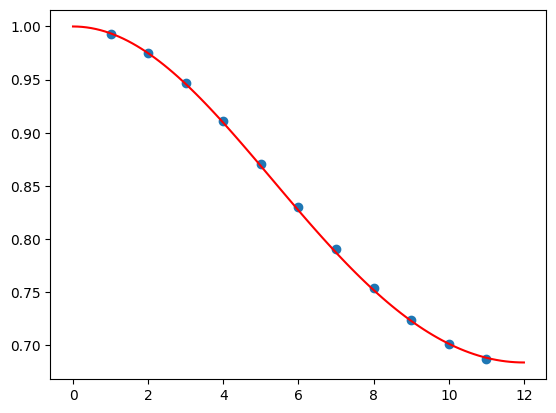

tensor([0.9929, 0.9754, 0.9469, 0.9112, 0.8707, 0.8299, 0.7907, 0.7543, 0.7238,
        0.7014, 0.6871])


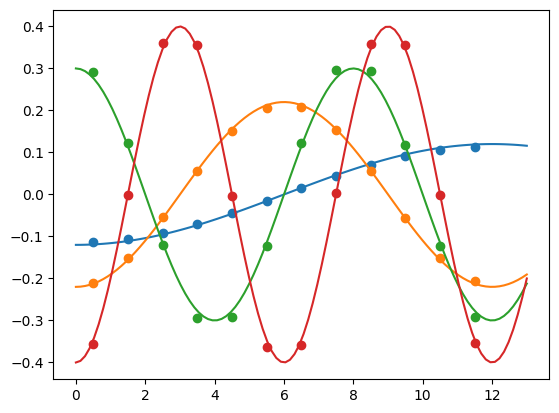

In [87]:
# EIGENVALUE SCATTERPLOT
if True:
    plt.scatter(np.arange(len(S)) + 1, S)
    x = np.linspace(0., polymer_length, 100)
    plt.plot(x, np.exp(-0.38*(np.sin(0.5*np.pi*x/polymer_length))**2), color="r")
    plt.show()
    print(S)

# EIGENFUNCTION SCATTERPLOTS
if True:
    x = np.linspace(0., polymer_length+1, 100)
    if True: # control whether we subtract the mean in making the comparison
        def plot_rouse_comparison(l, scale):
            plt.scatter(0.5+np.arange(polymer_length), trans_0.W[l-1, :] - trans_0.W[l-1, :].mean())
            plt.plot(x, scale*np.cos(l*np.pi*x/polymer_length))
    else:
        def plot_rouse_comparison(l, scale):
            plt.scatter(0.5+np.arange(polymer_length), trans_0.W[l-1, :])
            plt.plot(x, scale*np.cos(l*np.pi*x/polymer_length))
    plot_rouse_comparison(1, -0.12)
    plot_rouse_comparison(2, -0.22)
    plot_rouse_comparison(3, 0.3)
    plot_rouse_comparison(4, -0.4)
    plt.show()


### Polymer Dataset up to Degree 2

Now we analyze the polymer dataset again, but with features being 2nd degree polynomials. Note that to make this work, we need to include products of 2 distinct coordinates, not only squares of individual coordinates. If we have $n$ atoms, then the number of features here is $n + \binom{n}{2} = \frac{1}{2}n^2+\frac{1}{2}n$.

Given the time constant that we guessed from the previous fit, we should be able to multiply all the singular values from the previous analysis to get the ones we expect in our new analysis.

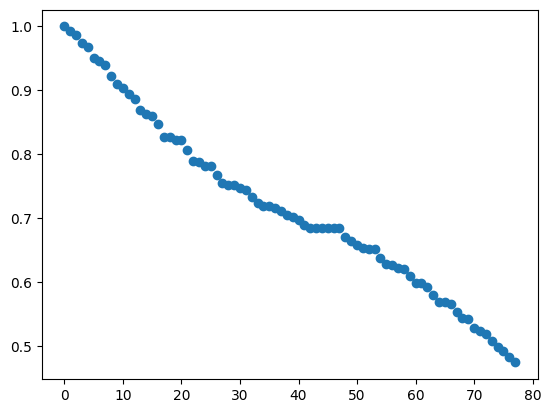

In [88]:

def f(x):
    return np.exp(-0.38*(np.sin(0.5*np.pi*x/polymer_length))**2)

S_0d = np.ones(1)
S_1d = f(np.arange(polymer_length)[1:])
S_2d = np.outer(S_1d, S_1d)[np.triu_indices(polymer_length - 1)]
S_expected = np.concatenate([S_0d, S_1d, S_2d])
S_expected = np.sort(S_expected)[::-1]

plt.plot(S_expected, linestyle=" ", marker="o")
plt.show()

In [89]:
# FEATURES ARE DEGREE 2 POLYNOMIALS

def batch_triu(x):
    """ given a tensor x of shape (batch, n, n), returns a
        tensor of shape (batch, n*(n+1)/2) where ans[i] is a
        flattened array of the upper triangular entries of x[i] """
    batch, n, m = x.shape
    assert n == m
    triu_indices = torch.triu_indices(n, n)
    triu_indices = n*triu_indices[0] + triu_indices[1] # prepare the indices for flattened dim
    return torch.index_select(x.reshape(batch, n*n), 1, triu_indices)

def get_degree_2(x):
    """ powers of x up to degree 2 where x.shape == (batch, n)
        output has shape (batch, n*(n+1)/2) """
    batch, n = x.shape
    outer = x.reshape(batch, n, 1) * x.reshape(batch, 1, n)
    return torch.cat([
        x,
        batch_triu(outer)
    ], dim=1)


if False: # test batch_triu
    box = torch.arange(9).reshape(1, 3, 3)
    x = torch.cat([box, 10*box, 100*box], dim=0)
    print(batch_triu(x))
    # expect: [[0,1,2,4,5,8],[0,10,20,40,50,80],[0,100,200,400,500,800]]

if False: # test get_degree_2
    print(get_degree_2(torch.tensor([[2., 3.], [5., 7.]])))
    # expect: [[2,3,4,6,9],[5,7,25,35,49]]

N = 100:


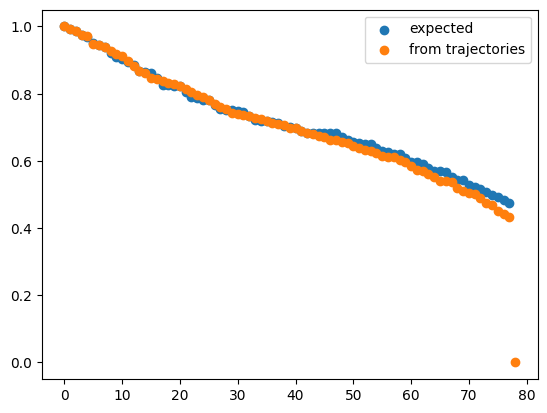

N = 1000:


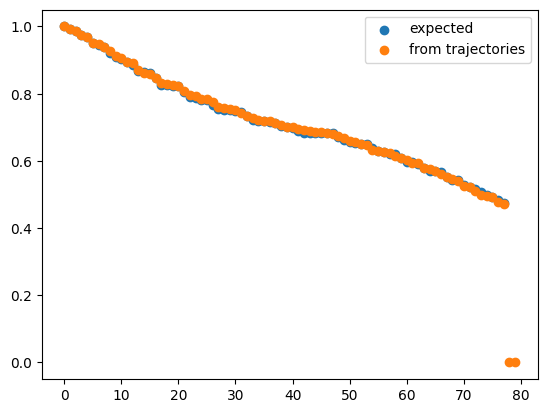

N = 10000:


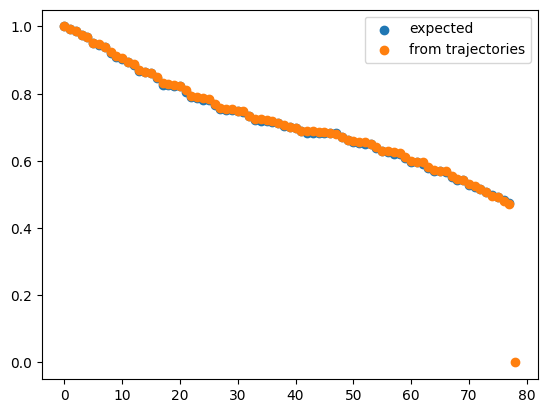

(78,) torch.Size([79])


In [90]:
# ANALYZE

N, L, _ = dataset_poly.shape
# check what happens if we use a subset of the data
for N_cut in [N//100, N//10, N]:
    print("N = %d:" % N_cut)
    # have to reshape first since the feature functions just expect a shape of (batch, coorddim)
    chi_0 = get_degree_2(dataset_poly[:N_cut, :-1].reshape(N_cut*(L-1), -1))
    chi_1 = get_degree_2(dataset_poly[:N_cut, 1: ].reshape(N_cut*(L-1), -1))
    trans_0, trans_1, K = vamp_score(chi_0, chi_1, mode="all")
    #f = trans_0(chi_0); decorr_test(f)
    #g = trans_1(chi_1); decorr_test(g)
    U, S, Vh = torch.linalg.svd(K)
    # EIGENVALUE SCATTERPLOT
    if True:
        S = torch.cat([torch.tensor([1]), S]) # add in the datapoint corresponding to "const" with eigenvalue 1
        plt.scatter(np.arange(len(S_expected)), S_expected, label="expected")
        plt.scatter(np.arange(len(S)), S, label="from trajectories")
        plt.legend()
        plt.show()

S_polymer_quadratic = S
print(S_expected.shape, S_polymer_quadratic.shape)

tensor(56.2599)


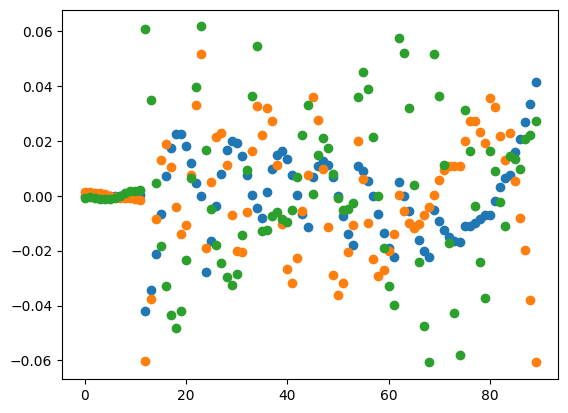

In [91]:
# VISUALIZING THE EIGENFUNCTIONS

print(S.sum())

# EIGENFUNCTION SCATTERPLOTS
if True:
    x = np.linspace(0., polymer_length+1, 100)
    sigmadim = trans_0.W.shape[1]
    if False: # control whether we subtract the mean in making the comparison
        def plot_eigenfunc(l):
            plt.scatter(np.arange(sigmadim), trans_0.W[l-1, :] - trans_0.W[l-1, :].mean())
    else:
        def plot_eigenfunc(l):
            plt.scatter(np.arange(sigmadim), trans_0.W[l-1, :])
    #plot_eigenfunc(1)
    #plot_eigenfunc(2)
    #plot_eigenfunc(3)
    #plot_eigenfunc(4)
    #plot_eigenfunc(5)
    plot_eigenfunc(78)
    plot_eigenfunc(77)
    plot_eigenfunc(76)

# TODO: figure out how to visualize this better!!!!
# TODO: why does the smallest mode have all these large quadratic coefficients???

## Training a Neural Network to Produce the Features

Here we use the VAMP score defined above as an objective function for our neural networks.




In [43]:
# ANALYZE WITH NEURAL NETWORK

import torch
import torch.nn as nn
import torch.nn.functional as F

# some hyperparameters:
lr = 0.0001
weight_decay = 0.01

def res_init(module):
    with torch.no_grad():
        if isinstance(module, nn.Linear):
            nn.init.kaiming_uniform_(module.weight)
            if module.bias is not None: module.bias.data.fill_(0.0)

'''
class ResLayer(nn.Module):
    """ see fig 1b in https://arxiv.org/pdf/1603.05027.pdf """
    def __init__(self, dim):
        super(ResLayer, self).__init__()
        self.dim = dim
        self.layers = nn.Sequential(
            nn.BatchNorm1d(dim),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(p=0.2),
            nn.Linear(dim, dim),
            nn.BatchNorm1d(dim),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Linear(dim, dim, bias=False),
        )
        self.apply(res_init)
    def forward(self, x):
        return x + self.layers(x)
'''

class ResLayer(nn.Module):
    def __init__(self, dim):
        super(ResLayer, self).__init__()
        self.dim = dim
        self.layers = nn.Sequential(
            nn.LeakyReLU(negative_slope=0.1),
            nn.Dropout(p=0.2),
            nn.Linear(dim, dim),
            nn.LeakyReLU(negative_slope=0.1),
            nn.Linear(dim, dim, bias=False),
        )
        self.apply(res_init)
    def forward(self, x):
        return x + self.layers(x)

class VAMPNet(nn.Module):
    def __init__(self, inp_dim, out_dim):
        super(VAMPNet, self).__init__()
        self.inp_dim = inp_dim
        self.out_dim = out_dim
        self.layers = nn.Sequential(
            nn.Linear(inp_dim, 256),
            ResLayer(256),
            nn.Linear(256, 256),
            ResLayer(256),
            nn.Linear(256, out_dim)
        )
    def forward(self, x):
        return self.layers(x)


def train_VAMPNet(dataset, epochs, out_dim=16, device="cuda", batch=200):
    """ train a VAMPNet for a particular system
    dataset - array of trajectories, shape is (N, L, dim)
    N - number of trajectories to create
    L - length of each trajectory """
    dataset = dataset.to(device)
    N, L, dim = dataset.shape
    # create the model
    model = VAMPNet(dim, out_dim)
    optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=weight_decay)
    model.to(device)
    print(model)
    for i in range(epochs):
        print("epoch", i)
        for j in range(0, N, batch):
            input_coords = dataset[j:j+batch]
            model.zero_grad()
            features = model.forward(input_coords.reshape(batch*L, dim)).reshape(batch, L, out_dim)
            chi_0 = features[:, :-1].reshape(batch*(L-1), out_dim)
            chi_1 = features[:, 1: ].reshape(batch*(L-1), out_dim)
            loss = -vamp_score(chi_0, chi_1)
            print("   step", j, ": loss =", float(loss.detach().to("cpu")))
            loss.backward()
            optimizer.step()
    return model



#### For simple 1d Ornstein-Uhlenbeck:

In [44]:
model = train_VAMPNet(dataset, 20)

VAMPNet(
  (layers): Sequential(
    (0): Linear(in_features=1, out_features=256, bias=True)
    (1): ResLayer(
      (layers): Sequential(
        (0): LeakyReLU(negative_slope=0.1)
        (1): Dropout(p=0.2, inplace=False)
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): LeakyReLU(negative_slope=0.1)
        (4): Linear(in_features=256, out_features=256, bias=False)
      )
    )
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ResLayer(
      (layers): Sequential(
        (0): LeakyReLU(negative_slope=0.1)
        (1): Dropout(p=0.2, inplace=False)
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): LeakyReLU(negative_slope=0.1)
        (4): Linear(in_features=256, out_features=256, bias=False)
      )
    )
    (4): Linear(in_features=256, out_features=16, bias=True)
  )
)
epoch 0
   step 0 : loss = -0.5903359651565552
   step 200 : loss = -0.6707485914230347
   step 400 : loss = -0.7104980945587158
   

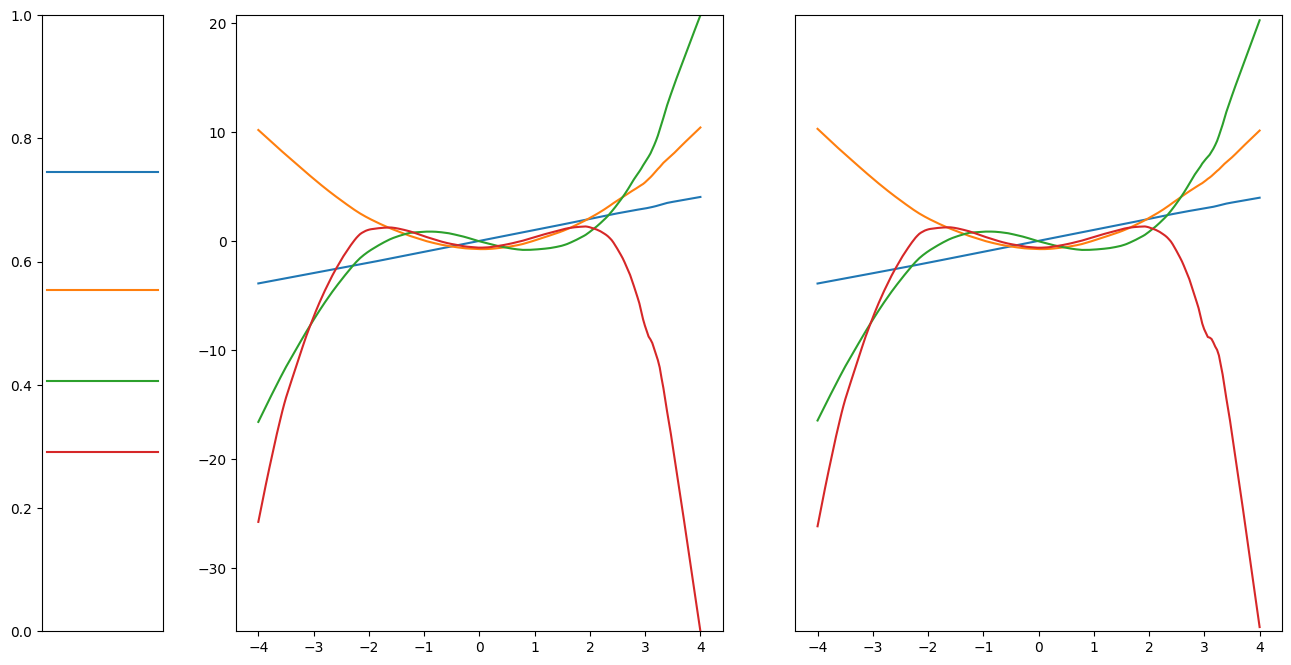

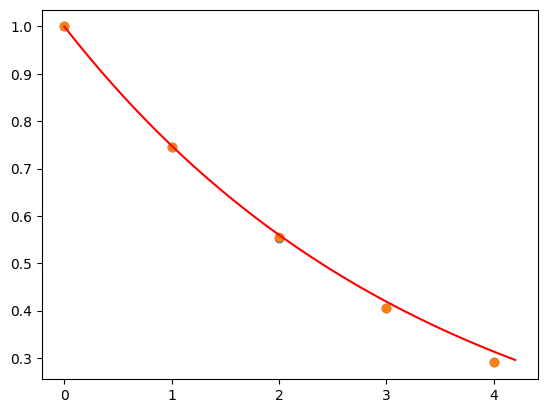

In [45]:
# TEST THE MODEL...

def test_model(model, dataset, G=None):
    with torch.no_grad():
        N, L, _ = dataset.shape
        # have to reshape first since the feature functions just expect a shape of (batch, coorddim)
        chi_0 = model(dataset[:N, :-1].reshape(N*(L-1), -1).to("cuda")).to("cpu")
        chi_1 = model(dataset[:N, 1: ].reshape(N*(L-1), -1).to("cuda")).to("cpu")
        trans_0, trans_1, K = vamp_score(chi_0, chi_1, mode="all")
        #f = trans_0(chi_0); decorr_test(f)
        #g = trans_1(chi_1); decorr_test(g)
        U, S, Vh = torch.linalg.svd(K.detach())
        if G is not None: # only keep top G singular values
            U, S, Vh = U[:, :G], S[:G], Vh[:G]
        trans_0 = Affine( Vh @ trans_0.W, trans_0.mu)
        trans_1 = Affine(U.T @ trans_1.W, trans_1.mu)
        get_eigenfeature_0 = lambda x: trans_0(model(x.to("cuda")).to("cpu")).detach()
        get_eigenfeature_1 = lambda x: trans_1(model(x.to("cuda")).to("cpu")).detach()
        plot_eigenthings(S, get_eigenfeature_0, get_eigenfeature_1)
        return S

model.eval()
S_ou_nn = test_model(model, dataset, G=4)

# COMPARE TO POWER RESULTS
if True:
    S_ou_nn = torch.cat([torch.tensor([1]), S_ou_nn]) # add in the datapoint corresponding to "const" with eigenvalue 1
    plt.scatter(np.arange(len(S_ou_nn)), S_ou_nn)
    plt.scatter(np.arange(len(S_ou_power)), S_ou_power)
    plt.plot(np.linspace(0., 4.2), np.exp(-0.29*(np.linspace(0., 4.2))), color="r") # manual fit copied from above
    plt.show()


Here we show a comparison with the actual Hermite polynomials. NOTE: All hermite polynomials of degree larger than 2 had to be scaled to match with the learned functions. TODO: Why is this so? Is there a good mathematical reason, or is it just a result of failure to fully learn the functions?

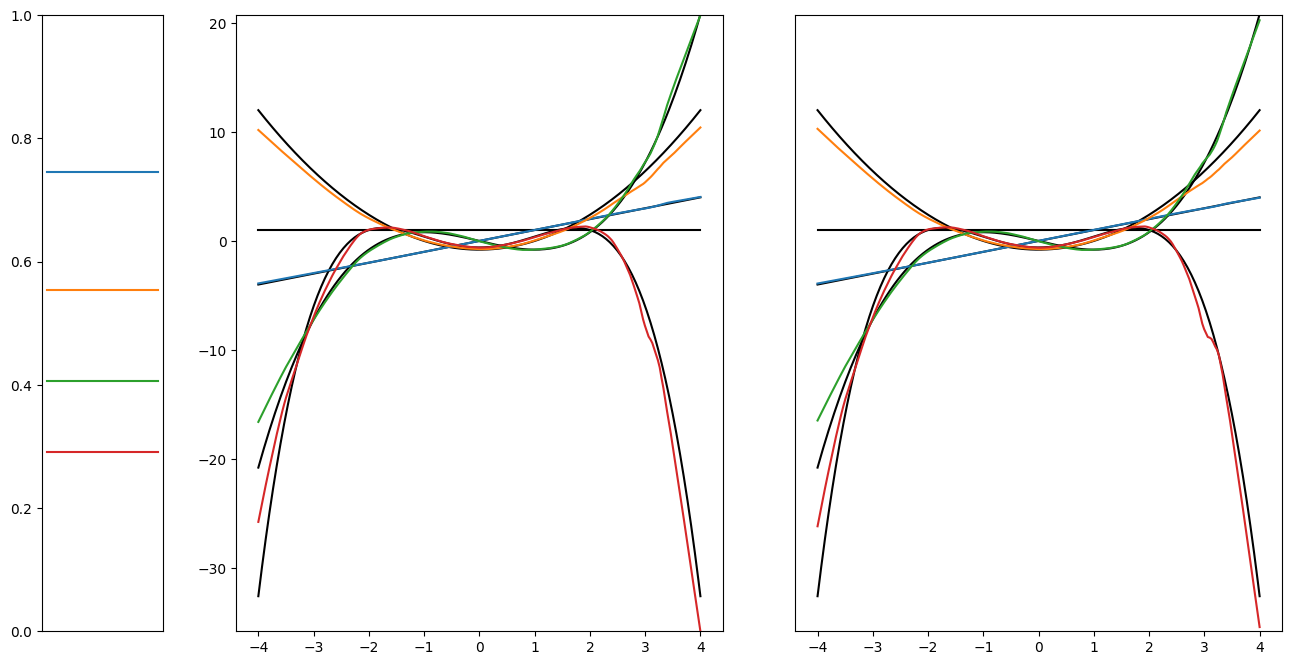

In [47]:
# ANALYZE BY COMPARING WITH THE EXPECTED HERMITE POLYNOMIALS

hermites = torch.tensor([
    [1., 0., 0., 0., 0.],
    [0., 1., 0., 0., 0.],
    [-1., 0., 1., 0., 0.],
    [0., -3., 0., 1., 0.],
    [3., 0., -6., 0., 1.],
])
def poly_eval(x, poly):
    deg = len(poly)
    powers = x[:, None] ** torch.arange(deg)[None, :]
    return (poly*powers).sum(-1)
def plot_hermites(ax, x, scalings=None):
    if scalings == None:
        scalings = torch.ones(hermites.shape[0])
    for i, hermite in enumerate(hermites):
        ax.plot(x, poly_eval(x, hermite*scalings[i]), color="black")

def plot_eigenthings_hermite(sing_vals, get_eigenfeature_0, get_eigenfeature_1, scalefn=(lambda x: 1.), range=(-4,4)):
    """ plot Koopman singular values and singular vectors for a 1D system """
    x = torch.linspace(*range, 240).reshape(240, 1)
    ef_0 = get_eigenfeature_0(x) * scalefn(x)
    ef_1 = get_eigenfeature_1(x) * scalefn(x)
    # do plotting
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, width_ratios=[1, 4, 4], figsize=(16, 8))
    # plot the hermites
    plot_hermites(ax2, x, [1.0, 1.0, 0.8, 0.4, -0.2])
    plot_hermites(ax3, x, [1.0, 1.0, 0.8, 0.4, -0.2])
    # plot the nn outputs
    x1, y1 = np.array([0., 1.]), np.array([1., 1.])
    for i, sigma in enumerate(sing_vals):
        ax1.plot(x1, sigma*y1)
        ax2.plot(x, ef_0[:, i])
        ax3.plot(x, ef_1[:, i])
    ax1.set_ylim(0., 1.)
    ax1.get_xaxis().set_visible(False)
    ymin, ymax = min(ef_0.min(), ef_1.min()), max(ef_0.max(), ef_1.max())
    ax2.set_ylim(ymin, ymax)
    ax3.set_ylim(ymin, ymax)
    ax3.get_yaxis().set_visible(False)
    plt.show()

def test_model_hermite(model, dataset, G=None):
    with torch.no_grad():
        N, L, _ = dataset.shape
        # have to reshape first since the feature functions just expect a shape of (batch, coorddim)
        chi_0 = model(dataset[:N, :-1].reshape(N*(L-1), -1).to("cuda")).to("cpu")
        chi_1 = model(dataset[:N, 1: ].reshape(N*(L-1), -1).to("cuda")).to("cpu")
        trans_0, trans_1, K = vamp_score(chi_0, chi_1, mode="all")
        #f = trans_0(chi_0); decorr_test(f)
        #g = trans_1(chi_1); decorr_test(g)
        U, S, Vh = torch.linalg.svd(K.detach())
        if G is not None: # only keep top G singular values
            U, S, Vh = U[:, :G], S[:G], Vh[:G]
        trans_0 = Affine( Vh @ trans_0.W, trans_0.mu)
        trans_1 = Affine(U.T @ trans_1.W, trans_1.mu)
        get_eigenfeature_0 = lambda x: trans_0(model(x.to("cuda")).to("cpu")).detach()
        get_eigenfeature_1 = lambda x: trans_1(model(x.to("cuda")).to("cpu")).detach()
        plot_eigenthings_hermite(S, get_eigenfeature_0, get_eigenfeature_1)
        return S

model.eval()
_ = test_model_hermite(model, dataset, G=4)


## Using VAMP NN learning techniques on the polymer

Now we'd like to try allowing a Neural Network to learn the eigenfunctions for the polymer system we considered above! We expect a close match in the spectra for maybe the first few eigenvalues, but we only went to second order, and there can be eigenvalues close to 1 whose eigenvectors use third powers of the coordinates, or even higher. Thus, we'd hope that the NN can find eigenvectors that do better than the analytic result we have aboe, at least after the first few eigenvectors.

Anyways, here is the code, which should be fairly similar to what we did in the 1d case:

In [52]:

model_poly = train_VAMPNet(dataset_poly, 50, out_dim=78)



VAMPNet(
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=256, bias=True)
    (1): ResLayer(
      (layers): Sequential(
        (0): LeakyReLU(negative_slope=0.1)
        (1): Dropout(p=0.2, inplace=False)
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): LeakyReLU(negative_slope=0.1)
        (4): Linear(in_features=256, out_features=256, bias=False)
      )
    )
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ResLayer(
      (layers): Sequential(
        (0): LeakyReLU(negative_slope=0.1)
        (1): Dropout(p=0.2, inplace=False)
        (2): Linear(in_features=256, out_features=256, bias=True)
        (3): LeakyReLU(negative_slope=0.1)
        (4): Linear(in_features=256, out_features=256, bias=False)
      )
    )
    (4): Linear(in_features=256, out_features=78, bias=True)
  )
)
epoch 0
   step 0 : loss = -9.308631896972656
   step 200 : loss = -9.576674461364746
   step 400 : loss = -9.672313690185547
   st

Previously when we had coordinates of up to quadratic degree, we calculated a particular singular-value spectrum that we expected based on the fact that we could only use up to 2 quanta total. In the general setting, it's possible to use arbitrarily many quanta, and we can make singular functions that decay slower than some of the 2 quanta singular functions by putting more of the quanta into the slowest Rouse modes. 

So we need to modify our "expected spectrum" to account for being able to use arbitrary numbers of quanta. That is what the following code allows us to do:

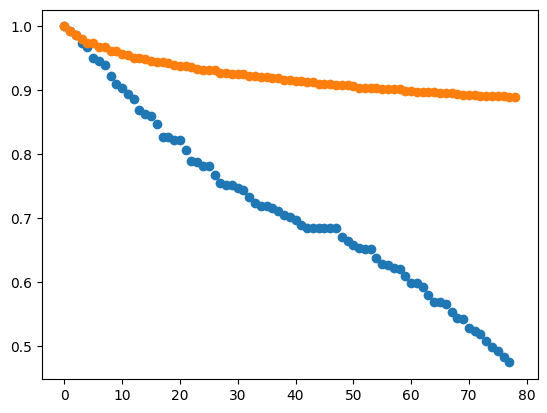

In [56]:
def log_f(x, polymer_length):
    return -0.38*(np.sin(0.5*np.pi*x/polymer_length))**2

def get_log_expected_singular_values(log_vals, n, show_ans_tups=False):
    """ get the expected singular values where arbitrary numbers
        of quanta can be put into a given mode
        log_vals: logarithms of the value for 1 quanta in a given mode.
                  Should be sorted in increasing order!
        n: we'll compute the largest (least negative) n singular values """
    def H(tup): # energy function
        return sum([tup[i]*log_vals[i] for i in range(dim)])
    dim = len(log_vals)
    ans_tups = [tuple([0]*dim)]
    for i in range(n):
        # get a list of candidates for the next largest tuple
        # a candidate must not be an existing tuple
        # all candidates are increments of some existing tuple
        candidate_tups = []
        for tup in ans_tups:
            for j in range(dim):
                lst = list(tup)
                lst[j] += 1
                inc_tup = tuple(lst)
                if inc_tup not in ans_tups:
                    candidate_tups.append(inc_tup)
                    break
        # find and add to the list the largest of the candidates
        i_best = 0
        H_best = -np.inf
        for i, tup in enumerate(candidate_tups):
            if H(tup) > H_best:
                i_best = i
                H_best = H(tup)
        ans_tups.append(candidate_tups[i_best])
    if show_ans_tups:
        for tup in ans_tups: print(tup)
    return [H(tup) for tup in ans_tups]


log_lin_S = log_f(1 + np.arange(11), 12)
S_exp_n = np.exp(get_log_expected_singular_values(log_lin_S, 78))

plt.scatter(np.arange(len(S_expected)), S_expected)
plt.scatter(np.arange(len(S_exp_n)), S_exp_n)
plt.show()



78 features shown
78 79 79


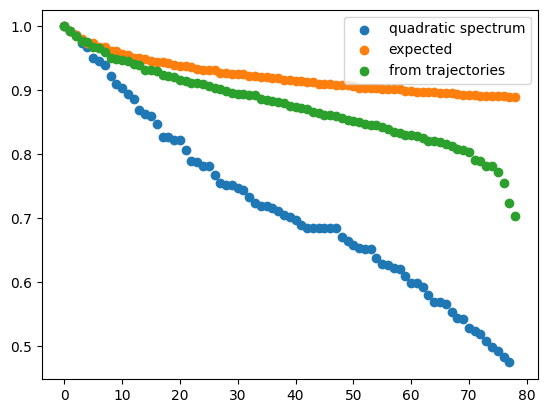

In [57]:
model_poly.eval()
print(model_poly.out_dim, "features shown")


def batched_model_eval(model, input, batch=16384):
    """ to avoid running out of memory, evaluate the model on a large tensor in batches
        Should only be called within torch.no_grad() context!
        model - the pytorch model to evaluate
        input - the input we are feeding to the model. shape: (N, channels)
        returns: the result of evaulating the model. shape: (N, out_chan) """
    N, channels = input.shape
    ans = torch.zeros(N, model.out_dim, device=input.device)
    for i in range(0, N, batch):
        ans[i:i+N] = model(input[i:i+N])
    return ans


def eval_model_poly():
    N, L, _ = dataset_poly.shape
    # have to reshape first since the feature functions just expect a shape of (batch, coorddim)
    dataset_poly_dev = dataset_poly.to("cuda")
    with torch.no_grad():
        chi = batched_model_eval(model_poly, # just evaluate once, since it's the same model
                                 dataset_poly_dev[:, :].reshape(N*L, -1))
        chi_0 = chi.reshape(N, L, -1)[:, :-1].reshape(N*(L-1), -1)
        chi_1 = chi.reshape(N, L, -1)[:, 1: ].reshape(N*(L-1), -1)
        trans_0, trans_1, K = vamp_score(chi_0, chi_1, mode="all")
        #f = trans_0(chi_0); decorr_test(f)
        #g = trans_1(chi_1); decorr_test(g)
        K = K.to("cpu") # do the rest of the computations on CPU....
        U, S, Vh = torch.linalg.svd(K)
        # EIGENVALUE SCATTERPLOT
        if True:
            S = torch.cat([torch.tensor([1]), S]) # add in the datapoint corresponding to "const" with eigenvalue 1
            print(len(S_expected), len(S_exp_n), len(S))
            plt.scatter(np.arange(len(S_expected)), S_expected, label="quadratic spectrum")
            plt.scatter(np.arange(len(S_exp_n)), S_exp_n, label="expected")
            plt.scatter(np.arange(len(S)), S, label="from trajectories")
            plt.legend()
            plt.show()
        return S

S_chain_nn = eval_model_poly()

### Evaluate on a Test Set

Now we generate a test set to compare the techniques. The methods we're evaluating consist of the transformations `trans_0` and `trans_1` (with the orthogonal matrices of the Koopman eigenfunctions baked in) and the function that generates the vectors $\chi$.



In [58]:
# GENERATE A TEST DATASET

test_dataset_polymer = subtract_cm_1d(get_dataset(sims["1D Polymer, Ornstein Uhlenbeck"], 10000, 100))


In [69]:
# DEFINE A MODEL CLASS TO ANALYZE THE DATA

class KoopmanModel:
    """ class with functions that give left and right features
        and Affine transforms that convert these features into L/R singular vectors
        and an array of singular values """
    def __init__(self, chi_0, chi_1, trans_0, trans_1, S):
        self.chi_0 = chi_0     # function: (-1, dim) -> (-1, featuredim)
        self.chi_1 = chi_1     # function: (-1, dim) -> (-1, featuredim)
        self.trans_0 = trans_0 # Affine: featuredim -> eigendim
        self.trans_1 = trans_1 # Affine: featuredim -> eigendim
        self.S = S             # (eigendim)
    def eval_score(self, test_dataset):
        """ compute an evaluation score that is closely analogous to the VAMP2 score """
        N, L, _ = test_dataset.shape
        with torch.no_grad():
            x = self.trans_0(self.chi_0(test_dataset[:, :-1].reshape(N*(L-1), -1)))
            y = self.trans_1(self.chi_1(test_dataset[:, 1:].reshape(N*(L-1), -1)))
            # get the predicted y based on x:
            sigma_dim, = self.S.shape ; print("dimension of singular values is: ", sigma_dim)
            y_hat = self.S*x[:, :sigma_dim]
            mserr = ((y_hat - y)**2).mean(0)
            var_y = (y**2).mean(0) - (y.mean(0))**2
            ratio = mserr / var_y # TODO / NOTE: maybe we need to add an epsilon here? not sure
            return (1 - ratio).sum()


def make_koopman_model(get_chi_0, get_chi_1, dataset):
    N, L, _ = dataset.shape
    chi_0 = get_chi_0(dataset[:, :-1].reshape(N*(L-1), -1))
    chi_1 = get_chi_1(dataset[:, 1:].reshape(N*(L-1), -1))
    trans_0, trans_1, K = vamp_score(chi_0, chi_1, mode="all")
    U, S, Vh = torch.linalg.svd(K)
    trans_0 = Affine( Vh @ trans_0.W, trans_0.mu)
    trans_1 = Affine(U.T @ trans_1.W, trans_1.mu)
    return KoopmanModel(get_chi_0, get_chi_1, trans_0, trans_1, S)



In [97]:


def get_chi_nn(model):
    def get(x):
        with torch.no_grad():
            x = x.to("cuda")
            ans = batched_model_eval(model, x)
            return ans.to("cpu")
    return get


koopmod_linear = make_koopman_model((lambda x: x), (lambda x: x), dataset_poly)
koopmod_quadratic = make_koopman_model(get_degree_2, get_degree_2, dataset_poly)
koopmod_nn = make_koopman_model(get_chi_nn(model_poly), get_chi_nn(model_poly), dataset_poly)


print("linear score:", koopmod_linear.eval_score(test_dataset_polymer).item())
print("linear score on training set: ", S_polymer_linear.sum().item())
print("Theory, linear:", np.exp(log_lin_S).sum())
print("")
print("quadratic score:", koopmod_quadratic.eval_score(test_dataset_polymer).item())
print("quadratic score on training set: ", S_polymer_quadratic.sum().item())
print("Theory, quadratic:", S_expected.sum())
print("")
print("neural net score:", koopmod_nn.eval_score(test_dataset_polymer).item())
print("neural net score on training set:", S_chain_nn.sum().item())
print("Theory, maximal:", S_exp_n[1:79].sum())




dimension of singular values is:  11
linear score: 7.793073654174805
linear score on training set:  9.184269905090332
Theory, linear: 9.171340848679819

dimension of singular values is:  78
quadratic score: 41.09223175048828
quadratic score on training set:  56.2598991394043
Theory, quadratic: 56.113805756568624

dimension of singular values is:  78
neural net score: 59.757362365722656
neural net score on training set: 69.14828491210938
Theory, maximal: 71.90362728631975
